In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from collections import defaultdict
from PIL import ImageColor
from matplotlib.colors import LinearSegmentedColormap
import re
import us
import squarify
import config
import warnings
warnings.filterwarnings('ignore')

# Load Data File 

In [2]:
csv_path ="public_emdat_Global_techNnatural.csv"
data = pd.read_csv(csv_path)
df=data

### Function definition to apply consistent plot theme 

In [3]:
def apply_plot_config():
    
    # Add config.background colors
    # Add config.background colors
    #plt.figure(figsize=(6,6))
    plt.gca().set_facecolor(config.background)
    plt.gcf().set_facecolor(config.background) 

    plt.gca().spines['top'].set_color(config.text)    # Top border
    plt.gca().spines['bottom'].set_color(config.text)  # Bottom border
    plt.gca().spines['left'].set_color(config.text)   # Left border
    plt.gca().spines['right'].set_color(config.text) # Right border

    # Customize tick bars
    plt.tick_params(axis='x', colors=config.text)  # Change color of x-axis tick bars
    plt.tick_params(axis='y', colors=config.text) # Change color of y-axis tick bars

# Data Cleansing

In [4]:
# Dropping unnecessary columns 
drop_columns = ['Historic']

if drop_columns:
    data.drop(columns=drop_columns, inplace=True)
cleaned_data = df

# Rename countries to reduce text length for graphs
replacement_map = {'United States of America': 'USA', 'Democratic Republic of the Congo': 'Congo', 'Russian Federation': 'Russia', 'United Republic of Tanzania': 'Tanzania'}
data['Country'] = data['Country'].replace(replacement_map)


Next, we are cleaning and modifying the data specific to USA to ensure all states are properly accounted for and subregions of a state are counted as an entire state

In [5]:
# Use Location column to understand which states are affected by each disaster and clean the column accordingly

# Supporting Function to Clean Location column 
def extract_state(x):
    if "(" in x:
        #x = x.replace(";",",")
        return re.findall(r'\((.*?)\)', x)
    if "," in x:
        #print("data with ,",x.split(","))
        return x.split(",")
    return [x]

# This line is if the location contains valid state. no need to continue further.
def segregate_state(x):
    x = re.sub(r'\s+s$', '', x) # Remove location with ' s' added to the valid state
    x = x.strip() # Remove extra spaces 
    x = re.sub(r'\s+and\s+', ',', x) # replace states that has 'and' with ','
    x = re.sub(r' near ', '', x) # remove state with near keyword
    x = re.sub(r'^.*?,\s*', '', x) # Regex to remove everything to the left of the comma
    
    if x in config.us_state_correction.keys():
        x = config.us_state_correction[x] # Check if the state is valid
    x_state = us.states.lookup(x).__str__()
    if not x_state == 'None':
        return x_state.capitalize().strip()
    else:
        # Find words that contain the substring
        x_state = [st for st in config.us_states_abbr.keys() if  st.lower() in x]
        if len(x_state) > 0:
            return x_state
        else:
            return x # if not valid return as-is

data_usa = data[data.Country == 'USA'].reset_index(drop=True)
locations=list(data_usa['Location'])

# Fix the following :
# We have some states in brackets '()'
# the state name is attached with config.text 'province' 
# The state name is attached with config.text 'state'
# Some location column has more than one state combined in one row. We will duplicate those rows and add rows for each state in seperate rows
# We will also fix letter cases.The capitalize() method returns a string where the first character is upper case, and the rest is lower case.

data_usa['Location'] = data_usa['Location'].fillna("")
pattern = '|'.join(['province', 'provinces','state','State','nan'])
# Extract config.text inside parent heses and split by ';'
data_usa['Location'] = data_usa['Location'].str.replace(pattern, '', regex=True)
data_usa['Location'] = data_usa['Location'].str.replace(',\s+', ',', regex=True)
data_usa['U.S State'] = data_usa['Location'].apply(extract_state)
data_usa_exploded = data_usa.explode('U.S State').reset_index(drop=True)
data_usa_exploded['U.S State'] = data_usa_exploded['U.S State'].apply(segregate_state)

# Cleaning the rows with Location as Nan 
# REferences :https://stackoverflow.com/questions/73285289/remove-rows-in-dataframe-only-if-a-certain-condition-is-met-using-pandas
data_usa_exploded['U.S State'].dropna(axis=0,inplace=True) # aqbove one is more efficient 
data_usa_exploded.reset_index(drop=True)
data_usa_exploded["U.S State"] = data_usa_exploded["U.S State"].str.capitalize()
data_usa_natural_explode = data_usa_exploded[data_usa_exploded['Disaster Group'] == 'Natural']
data_usa_natural_explode['U.S State']

# Remove the Location not in Valid US State 
data_usa_natural_explode.reset_index(drop=True,inplace=True)
data_usa_natural_explode_us_state = data_usa_natural_explode[data_usa_natural_explode['U.S State'].isin(config.us_state_names)]
#data_usa = data_usa_natural_explode_us_state
#data_usa.shape

## Exploratory analysis

### What types of disasters have been recorded worldwide to date?

In [6]:
diaster_start_year = cleaned_data['End Year'].min() # 2001
diaster_end_year = cleaned_data['End Year'].max() # 2024 
print(f"Disaster Types recorded worldwide & its count recorded from {diaster_start_year} to {diaster_end_year} :")
print(f"{'-'*65}")
hierachial_disaster_group = cleaned_data.groupby(['Disaster Group','Disaster Subgroup','Disaster Type']).size().reset_index(name='count')
pd.DataFrame(hierachial_disaster_group.sort_values(by=['Disaster Group', 'Disaster Subgroup', 'count'], ascending=[True, True, False]))

Disaster Types recorded worldwide & its count recorded from 2000 to 2024 :
-----------------------------------------------------------------


,Disaster Group,Disaster Subgroup,Disaster Type,count
1,Natural,Biological,Epidemic,868
2,Natural,Biological,Infestation,29
0,Natural,Biological,Animal incident,1
3,Natural,Climatological,Drought,415
5,Natural,Climatological,Wildfire,316
4,Natural,Climatological,Glacial lake outburst flood,5
6,Natural,Extra-terrestrial,Impact,1
7,Natural,Geophysical,Earthquake,670
9,Natural,Geophysical,Volcanic activity,128
8,Natural,Geophysical,Mass movement (dry),13


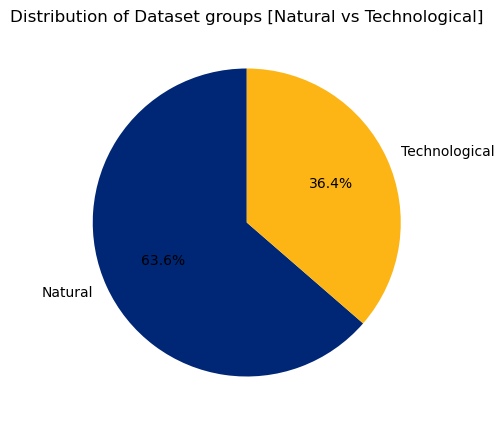

In [7]:
disaster_group_data = hierachial_disaster_group.groupby("Disaster Group")["count"].sum().reset_index()
disaster_subgroup_data = hierachial_disaster_group.groupby(["Disaster Group", "Disaster Subgroup"])["count"].sum().reset_index()

# Pie Chart 1: Technology vs. Natural Disasters
plt.figure(figsize=(5, 5))
plt.pie(
    disaster_group_data["count"],
    labels=disaster_group_data["Disaster Group"],
    autopct='%1.1f%%',
    startangle=90,
    colors=config.berkeley_palette_primary
)
plt.title("Distribution of Dataset groups [Natural vs Technological]")
pass

### Analyse Distribution of Disaster sub group 

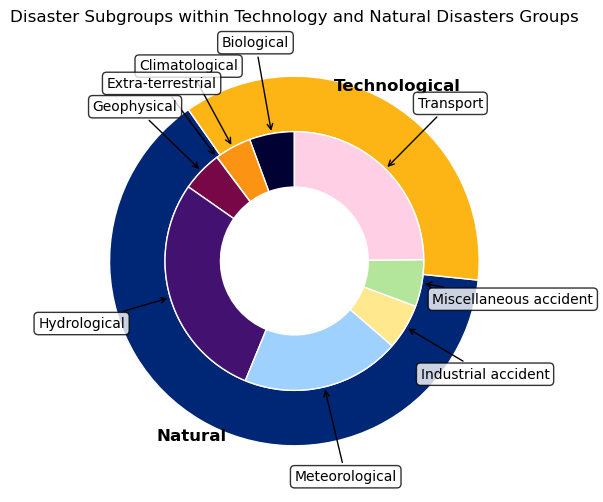

In [8]:
outer_pie_data = (
    cleaned_data.groupby("Disaster Group")
    .size()
    .reset_index(name = "count")
)
inner_pie_data = (
    cleaned_data.groupby(["Disaster Group", "Disaster Subgroup"])
    .size()
    .reset_index(name = "count")
)

fig, ax = plt.subplots(figsize=(7, 6))

#Outer Group
outer_pie, _ = ax.pie(
    outer_pie_data["count"],
    labels = None,
    radius = 1,
    colors = config.berkeley_palette_primary,
    wedgeprops=dict(width=0.3, edgecolor='w'),
    startangle= 125
)

for i, p in enumerate(outer_pie):
    theta = (p.theta2 - p.theta1)/2 + p.theta1

    x = 1.1 * np.cos(np.radians(theta))
    y = 1.1 * np.sin(np.radians(theta))

    ax.text(
        x, y,
        outer_pie_data["Disaster Group"].iloc[i],
        fontsize = 12, ha = "center", va = "center", fontweight="bold", color="black"
    )


inner_pie, _ = ax.pie(
    inner_pie_data["count"],
    radius = 1-0.3,
    colors = (config.berkeley_palette_preferred_dark + config.berkeley_palette_alternative_light + config.berkeley_palette_alternative_medium)[:len(disaster_subgroup_data)],
    labels= None,
    wedgeprops = dict(width = 0.3, edgecolor='w'),
    startangle = 90
)

bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
arrow_props = dict(arrowstyle="->", color="black", lw=1)

for i, (p, label) in enumerate(zip(inner_pie, inner_pie_data["Disaster Subgroup"])):
    theta = (p.theta2 - p.theta1)/2 + p.theta1

    x = (1 - 0.3) * np.cos(np.radians(theta))
    x_label = 1.2 * np.cos(np.radians(theta))
    y = (1 - 0.3) * np.sin(np.radians(theta))
    y_label = 1.2 * np.sin(np.radians(theta))

    ax.annotate(
        label,
        xy = (x, y),
        xytext = (x_label, y_label),
        arrowprops = arrow_props,
        bbox = bbox_props,
        fontsize = 10, ha = "center", va = "center"
    )

ax.set(aspect="equal", title = "Disaster Subgroups within Technology and Natural Disasters Groups")
pass


## Objective 1a. What are the top 10 countries with the most disasters?

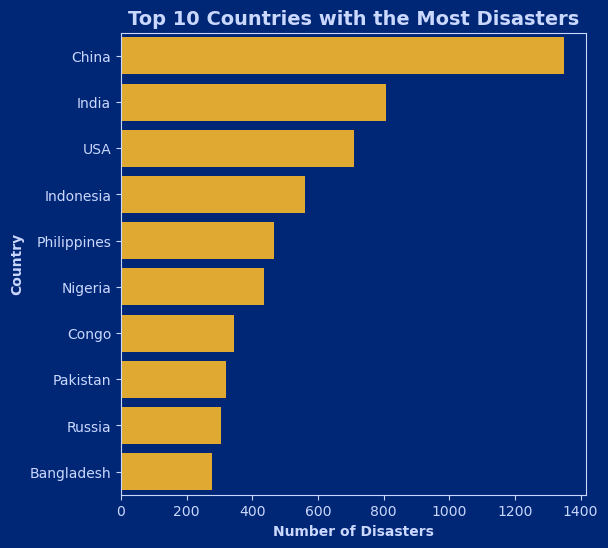

In [9]:
# Aggregate disaster counts by country
top_countries = data['Country'].value_counts().head(10).reset_index()
top_countries.columns = ['Country', 'Disaster Count']

# Plot using Seaborn
plt.figure(figsize=(6, 6))
sns.barplot(data=top_countries, x='Disaster Count', y='Country', color=config.graph)
plt.title('Top 10 Countries with the Most Disasters', fontsize=14,weight='bold',color=config.text)
plt.xlabel('Number of Disasters',fontdict={'weight': 'bold'},color=config.text)
plt.ylabel('Country',fontdict={'weight': 'bold'},color=config.text)
apply_plot_config()

### 1a. What are the US states with most disaster? 

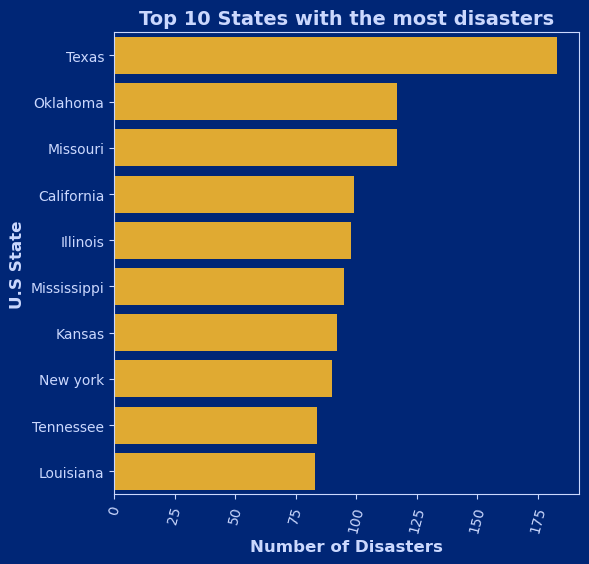

In [10]:
# 1a. Total Disasters - U.S State
# Aggregate disaster counts by country
top_states = data_usa_exploded['U.S State'].value_counts().head(10).reset_index()
top_states.columns = ['U.S State', 'Disaster Count']

# Graph
plt.figure(figsize=(6,6))
sns.barplot(data=top_states,x='Disaster Count',y='U.S State',color=config.graph)
plt.xlabel('Number of Disasters',fontsize=12,fontweight='bold',color=config.text)
plt.xticks(fontsize=10,color=config.text)
plt.ylabel('U.S State',fontsize=12,fontweight='bold',color=config.text)
plt.yticks(fontsize=10,color=config.text)
plt.title('Top 10 States with the most disasters',fontsize=14,fontweight='bold',color=config.text)
plt.xticks(rotation=75)
apply_plot_config()
pass

## Objective 1b : Total Duration of Disaster 

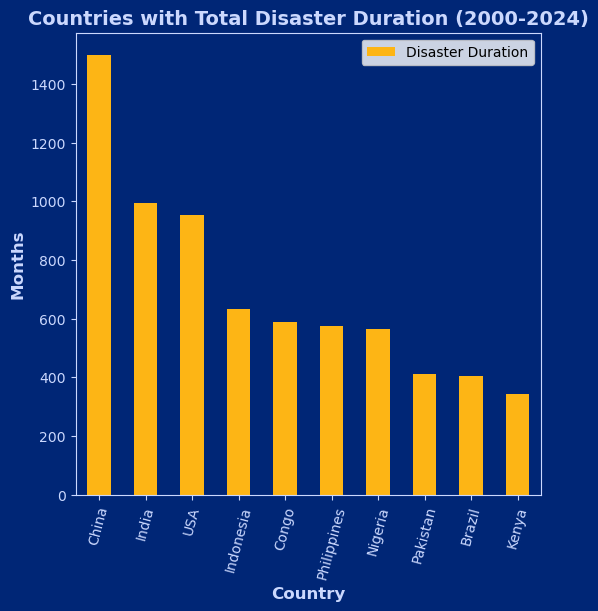

In [11]:
# 1b. Duration of Disaster - Global

# Remove records which do not have either a Start Month or End month (total 203 rows)
# print(data.shape) # (15999, 24)

o1b_data = data[~(data['Start Month'].isnull() | data['End Month'].isnull())].reset_index()
# print(j_data.shape) # (15796, 24)

# Create new columns with Start and End dates using day 1 of month as start and last day for end
o1b_data['Start Month'] = o1b_data['Start Month'].astype(int)
o1b_data['End Month'] = o1b_data['End Month'].astype(int)
o1b_data['Start Year'] = o1b_data['Start Year'].astype(str)
o1b_data['End Year'] = o1b_data['End Year'].astype(str)

o1b_data['Start Time'] = o1b_data['Start Year'] + '-' + o1b_data['Start Month'].astype(str)
o1b_data['End Time'] = o1b_data['End Year'] + '-' + o1b_data['End Month'].astype(str)

o1b_data['Start Time'] = pd.to_datetime(o1b_data['Start Time'], format='%Y-%m')
o1b_data['Start Time'] = o1b_data['Start Time'] + pd.offsets.Day(0)

o1b_data['End Time'] = pd.to_datetime(o1b_data['End Time'], format='%Y-%m')
o1b_data['End Time'] = o1b_data['End Time'] + pd.offsets.MonthEnd(0)

# Calculate the duration as difference between start and end dates
o1b_data['Disaster Duration'] = round(((o1b_data['End Time'] - o1b_data['Start Time']).dt.days) / 30) # Months

# Group the data by Country and sum of duration sorted descending and pull top 10 countries
group_data = o1b_data.groupby('Country')['Disaster Duration'].sum().sort_values(ascending=False)
country_df = group_data.reset_index().set_index('Country').head(10)

country_df.plot.bar(color=config.graph,figsize=(6,6))
plt.xlabel('Country',fontsize=12,fontweight='bold',color=config.text)
plt.xticks(fontsize=10,color=config.text)
plt.ylabel('Months',fontsize=12,fontweight='bold',color=config.text)
plt.yticks(fontsize=10,color=config.text)
plt.title('Countries with Total Disaster Duration (2000-2024)',fontsize=14,fontweight='bold',color=config.text)
plt.xticks(rotation=75)

apply_plot_config() 

pass

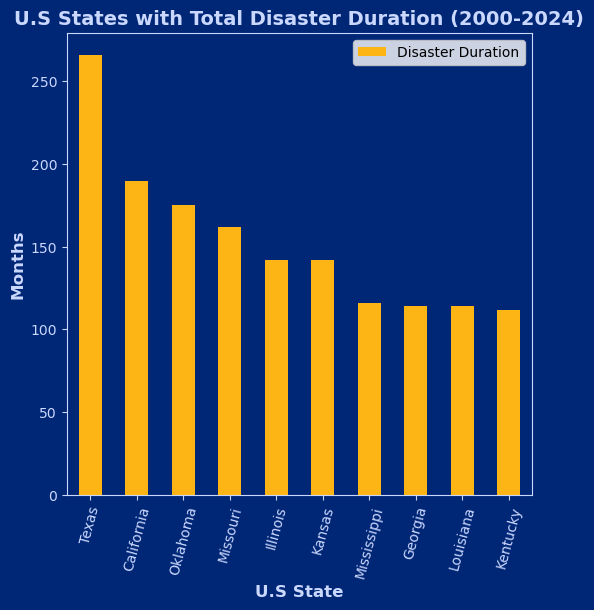

In [12]:
# 1b. Duration of Disaster - United States

o1b_data_us = data_usa_exploded[~(data_usa_exploded['Start Month'].isnull() | data_usa_exploded['End Month'].isnull())].reset_index(drop=True)

# Create new columns with Start and End dates using day 1 of month as start and last day for end
o1b_data_us['Start Month'] = o1b_data_us['Start Month'].astype(int)
o1b_data_us['End Month'] = o1b_data_us['End Month'].astype(int)
o1b_data_us['Start Year'] = o1b_data_us['Start Year'].astype(str)
o1b_data_us['End Year'] = o1b_data_us['End Year'].astype(str)

o1b_data_us['Start Time'] = o1b_data_us['Start Year'] + '-' + o1b_data_us['Start Month'].astype(str)
o1b_data_us['End Time'] = o1b_data_us['End Year'] + '-' + o1b_data_us['End Month'].astype(str)

o1b_data_us['Start Time'] = pd.to_datetime(o1b_data_us['Start Time'], format='%Y-%m')
o1b_data_us['Start Time'] = o1b_data_us['Start Time'] + pd.offsets.Day(0)

o1b_data_us['End Time'] = pd.to_datetime(o1b_data_us['End Time'], format='%Y-%m')
o1b_data_us['End Time'] = o1b_data_us['End Time'] + pd.offsets.MonthEnd(0)

# Calculate the duration as difference between start and end dates
o1b_data_us['Disaster Duration'] = round((o1b_data_us['End Time'] - o1b_data_us['Start Time']).dt.days / 30) # Months
# Group the data by Country and sum of duration sorted descending and pull top 10 countries
us_group_data = o1b_data_us.groupby('U.S State')['Disaster Duration'].sum().sort_values(ascending=False)

us_df = us_group_data.reset_index().set_index('U.S State').head(10)

us_df.plot.bar(color=config.graph,figsize=(6,6))
plt.xlabel('U.S State',fontsize=12,fontweight='bold',color=config.text)
plt.xticks(fontsize=10,color=config.text)
plt.ylabel('Months',fontsize=12,fontweight='bold',color=config.text)
plt.yticks(fontsize=10,color=config.text)
plt.title('U.S States with Total Disaster Duration (2000-2024)',fontsize=14,fontweight='bold',color=config.text)
plt.xticks(rotation=75)

apply_plot_config() 

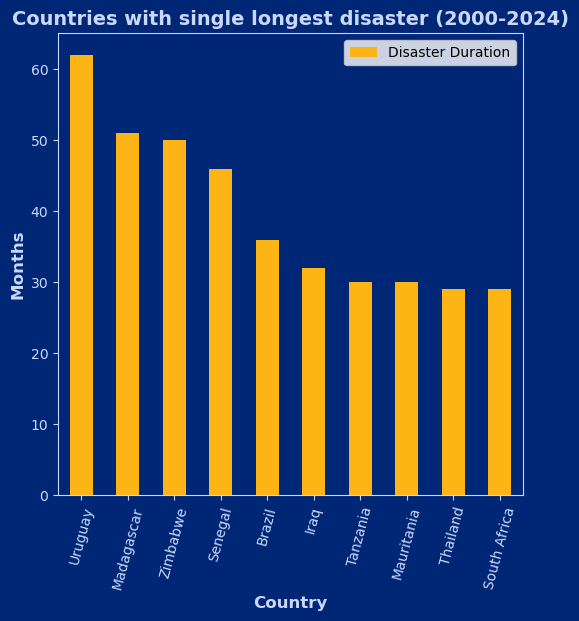

In [13]:
# 1b. Place with longest disaster - Country

# Group the data by Country and sum of duration sorted descending and pull top 10 countries
group_data = o1b_data.groupby('Country')['Disaster Duration'].max().sort_values(ascending=False)
country_df_l = group_data.reset_index().set_index('Country').head(10)

country_df_l.plot.bar(color=config.graph,figsize=(6,6))
plt.xlabel('Country',fontsize=12,fontweight='bold',color=config.text)
plt.xticks(fontsize=10,color=config.text)
plt.ylabel('Months',fontsize=12,fontweight='bold',color=config.text)
plt.yticks(fontsize=10,color=config.text)
plt.title('Countries with single longest disaster (2000-2024)',fontsize=14,fontweight='bold',color=config.text)
plt.xticks(rotation=75)

apply_plot_config()

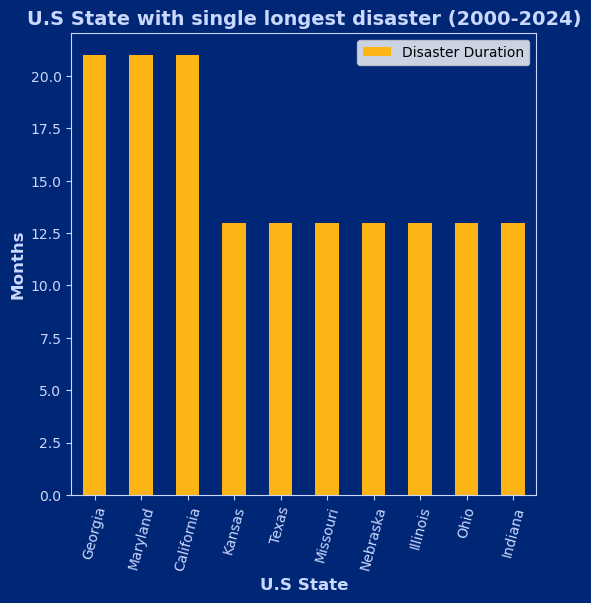

In [14]:
# 1b. Place with longest disaster - U.S State

# Group the data by Country and sum of duration sorted descending and pull top 10 countries
group_data = o1b_data_us.groupby('U.S State')['Disaster Duration'].max().sort_values(ascending=False)
state_df_l = group_data.reset_index().set_index('U.S State').head(10)

state_df_l.plot.bar(color=config.graph,figsize=(6,6))
plt.xlabel('U.S State',fontsize=12,fontweight='bold',color=config.text)
plt.xticks(fontsize=10,color=config.text)
plt.ylabel('Months',fontsize=12,fontweight='bold',color=config.text)
plt.yticks(fontsize=10,color=config.text)
plt.title('U.S State with single longest disaster (2000-2024)',fontsize=14,fontweight='bold',color=config.text)
plt.xticks(rotation=75)

apply_plot_config() 

## Objective 1c - People Impacted

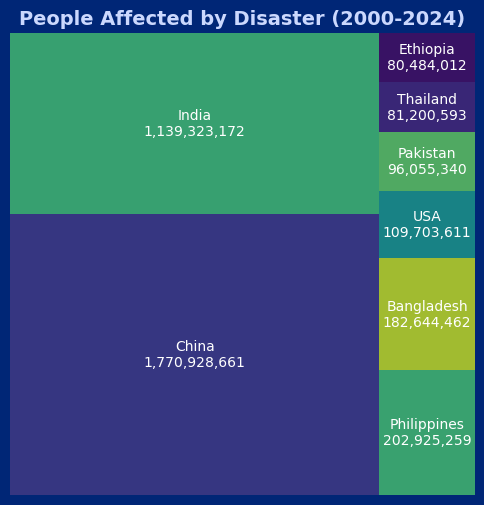

In [15]:
# 1c. People Impacted - Global
# The column in focus will be "Total Affected"
# Fill null values as zero
data['Total Affected'].fillna(0, inplace=True)
# Type cast total affected as int
data['Total Affected'] = data['Total Affected'].astype(int)

# Group data and select the top 10 countries by deaths
group_data_aff = data.groupby('Country')['Total Affected'].sum().sort_values(ascending=False)
affected_df = group_data_aff.reset_index().set_index('Country').head(8)

# Prepare data for the treemap
sizes = affected_df['Total Affected'].values
labels = [f"{country}\n{count:,}" for country, count in zip(affected_df.index, sizes)]  # Add counts to labels

# Create the treemap
plt.figure(figsize=(6, 6))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, text_kwargs={'fontsize': 10, 'color': 'white'})

# Formatting
plt.title('People Affected by Disaster (2000-2024)', fontsize=14, fontweight='bold', color=config.text)
plt.axis('off')  # Turn off the axis for a cleaner look

apply_plot_config()

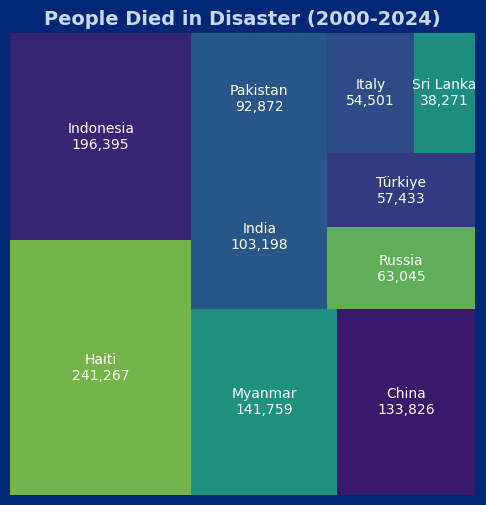

In [16]:
# 1c. People Impacted - Global

# The column in focus will be "Total Deaths"

# Fill null values as zero
data['Total Deaths'].fillna(0, inplace=True)
# Type cast total affected as int
data['Total Deaths'] = data['Total Deaths'].astype(int)

# Group data and select the top 10 countries by deaths
group_data_deaths = data.groupby('Country')['Total Deaths'].sum().sort_values(ascending=False)
deaths_df = group_data_deaths.reset_index().set_index('Country').head(10)

# Prepare data for the treemap
sizes = deaths_df['Total Deaths'].values
labels = [f"{country}\n{count:,}" for country, count in zip(deaths_df.index, sizes)]  # Add counts to labels
#colors = cm.viridis([i / len(sizes) for i in range(len(sizes))])  # Generate a colormap

# Create the treemap
plt.figure(figsize=(6, 6))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, text_kwargs={'fontsize': 10, 'color': 'white'})

# Formatting
plt.title('People Died in Disaster (2000-2024)', fontsize=14, fontweight='bold', color=config.text)
plt.axis('off')  # Turn off the axis for a cleaner look
apply_plot_config()


## Objective 2 - Common types of disasters

<Figure size 1200x600 with 0 Axes>

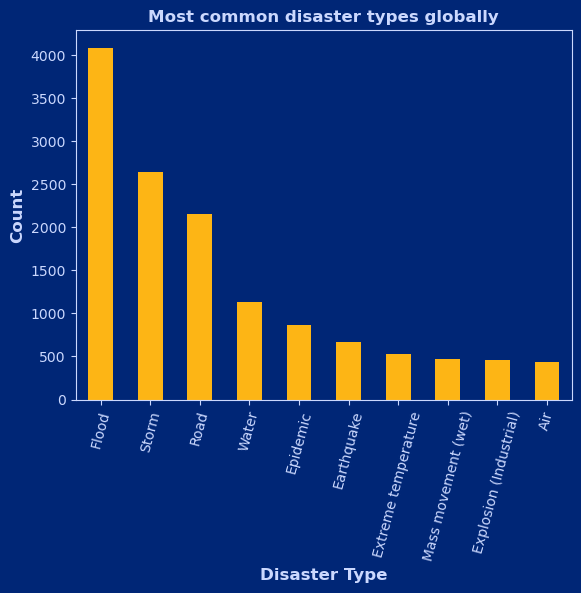

In [17]:
# Most common  Disaster Types - globally 
global_disaster_types = data["Disaster Type"].value_counts().reset_index()
global_disaster_types.columns = ["Disaster Type", "Frequency"]

plt.figure(figsize=(12, 6))
global_disaster_types.head(10).plot(kind='bar', x="Disaster Type", y="Frequency", color=config.graph, legend=False) ##002676
plt.title("Most common disaster types globally",weight='bold',color=config.text)
plt.xlabel("Disaster Type", fontsize=12,fontdict={'weight': 'bold'},color=config.text)
plt.ylabel("Count", fontsize=12,fontdict={'weight': 'bold'},color=config.text)
plt.xticks(rotation=75)
apply_plot_config()
pass

<Figure size 1200x600 with 0 Axes>

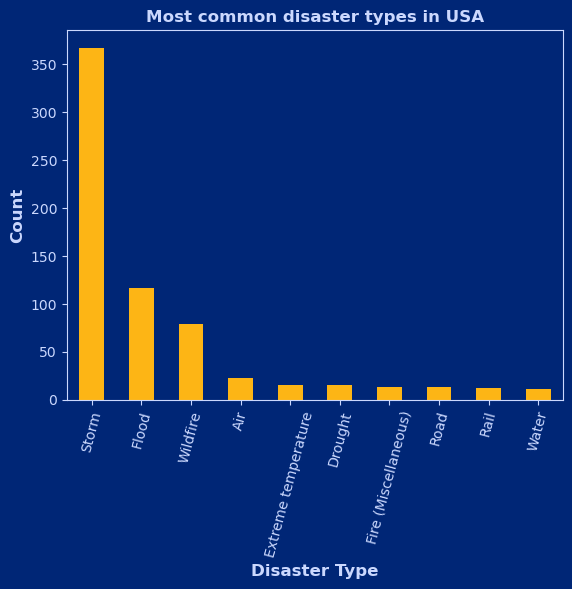

In [18]:
#Most common disaster type in US 
us_disaster_types = data_usa["Disaster Type"].value_counts().reset_index()
us_disaster_types.columns = ["Disaster Type", "Frequency"]

plt.figure(figsize=(12, 6))
us_disaster_types.head(10).plot(kind='bar', x="Disaster Type", y="Frequency", color=config.graph, legend=False)
plt.title("Most common disaster types in USA",weight='bold',color=config.text)
plt.xlabel("Disaster Type", fontsize=12,fontdict={'weight': 'bold'},color=config.text)
plt.ylabel("Count", fontsize=12,fontdict={'weight': 'bold'},color=config.text)
plt.xticks(rotation=75)
apply_plot_config()
pass

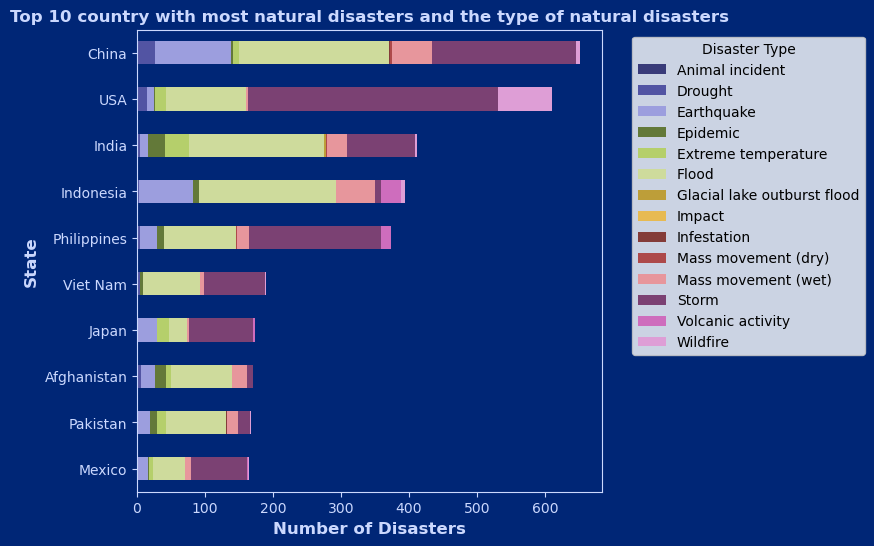

In [19]:
# Top 10 Country with most natural disaster type 
data_natural = data[data["Disaster Group"] == "Natural"]
natural_count = data_natural["Country"].value_counts().head(10)
natural_type = data_natural.groupby(["Country", "Disaster Type"]).size().unstack(fill_value=0)

top_10_countries = natural_count.index
disaster_type_top_10 = natural_type.loc[top_10_countries]
disaster_type_top_10_sorted = disaster_type_top_10.loc[disaster_type_top_10.sum(axis=1).sort_values(ascending=True).index]

cmap = cm.get_cmap('tab20b') # Colour map (there are many others)tab20

disaster_type_top_10_sorted.plot(kind="barh", stacked=True, figsize=(6,6),colormap=cmap)
plt.title("Top 10 country with most natural disasters and the type of natural disasters",weight='bold',color=config.text)
plt.xlabel("Number of Disasters", fontsize=12,fontdict={'weight': 'bold'},color=config.text)
plt.ylabel("State", fontsize=12,fontdict={'weight': 'bold'},color=config.text)
plt.legend(title="Disaster Type", bbox_to_anchor=(1.05, 1), loc="upper left")
apply_plot_config()
pass

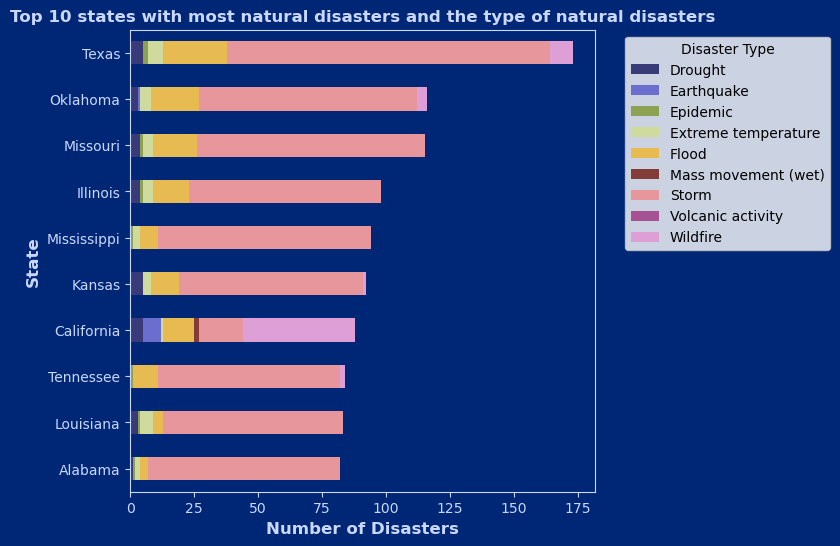

In [20]:
# Top 10 US State with most natural disaster type 
#data_usa_natural = data_usa_exploded[data_usa["Disaster Group"] == "Natural"]
natural_usa_count = data_usa_natural_explode_us_state["U.S State"].value_counts().head(10)
natural_usa_type = data_usa_natural_explode_us_state.groupby(["U.S State", "Disaster Type"]).size().unstack(fill_value=0)

top_10_states = natural_usa_count.index
disaster_type_usa_top_10 = natural_usa_type.loc[top_10_states]
disaster_type_usa_top_10_sorted = disaster_type_usa_top_10.loc[disaster_type_usa_top_10.sum(axis=1).sort_values(ascending=True).index]
cmap = cm.get_cmap('tab20b') # Colour map (there are many others)
disaster_type_usa_top_10_sorted.plot(kind="barh", stacked=True, figsize=(6,6),colormap=cmap)
plt.title("Top 10 states with most natural disasters and the type of natural disasters",weight='bold',color=config.text)
plt.xlabel("Number of Disasters", fontsize=12,fontdict={'weight': 'bold'},color=config.text)
plt.ylabel("State", fontsize=12,fontdict={'weight': 'bold'},color=config.text)
plt.legend(title="Disaster Type", bbox_to_anchor=(1.05, 1), loc="upper left")

apply_plot_config()

pass

## 3. Determine if there are any patterns in when and how many disasters occur.

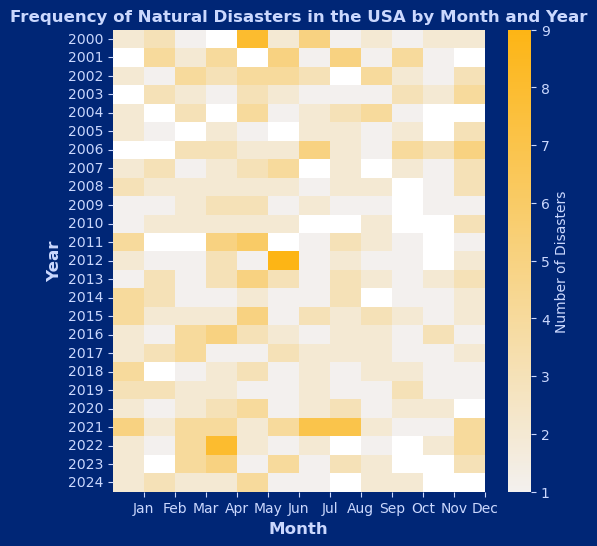

In [21]:
# Clean the data to include correct start and end date, and remove any data that doesn't have a start or end date
cleaned_date_data = data[~(data['Start Month'].isnull() | data['End Month'].isnull())].reset_index(drop=True)

usa_natural_disasters_date_data = (
    cleaned_date_data[
        (cleaned_date_data["Country"] == "USA") &
        (cleaned_date_data["Disaster Group"] == "Natural")
    ]
)
usa_natural_disaster_frequency = (usa_natural_disasters_date_data.groupby(["Start Year", "Start Month"]).size().reset_index(name="Frequency"))
usa_natural_disasters_matrix = (usa_natural_disaster_frequency.pivot(index="Start Year", columns="Start Month", values="Frequency"))

fig = plt.figure(figsize=(6,6))
berkeley_prim_grad = sns.color_palette("blend:#FDB515,#002676", as_cmap=True)
ax = sns.heatmap(usa_natural_disasters_matrix, cmap=sns.light_palette("#FDB515",as_cmap=True),cbar=True, annot=False) # works does not look good

# Access the color bar
colorbar = ax.collections[0].colorbar
# Change the color bar tick label color
colorbar.ax.yaxis.set_tick_params(color=config.text)  # Change tick label color

colorbar.set_label('Number of Disasters', color=config.text)
# Change the color bar title config.text color (if a title is set)
colorbar.ax.tick_params(colors=config.text)
plt.title("Frequency of Natural Disasters in the USA by Month and Year",weight='bold',color=config.text)
plt.xlabel("Month", fontsize=12,fontdict={'weight': 'bold'},color=config.text)
plt.ylabel("Year", fontsize=12,fontdict={'weight': 'bold'},color=config.text)
plt.xticks(ticks=range(1,13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
apply_plot_config()
plt.gca().set_facecolor('white')


## Refering to secondary dataset to help understand trends over a bigger timeframe in the USA

In [22]:
state_freq_data = pd.read_csv('state_freq_data.csv', skiprows=1)
state_cost_data = pd.read_csv('state-cost-data.csv', skiprows=1)


In [23]:
abbreviation_to_name = {
    "AK": "Alaska",
    "AL": "Alabama",
    "AR": "Arkansas",
    "AZ": "Arizona",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "IA": "Iowa",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "MA": "Massachusetts",
    "MD": "Maryland",
    "ME": "Maine",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MO": "Missouri",
    "MS": "Mississippi",
    "MT": "Montana",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "NE": "Nebraska",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NV": "Nevada",
    "NY": "New York",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VA": "Virginia",
    "VT": "Vermont",
    "WA": "Washington",
    "WI": "Wisconsin",
    "WV": "West Virginia",
    "WY": "Wyoming",
    "DC": "District of Columbia",
    "AS": "American Samoa",
    "GU": "Guam GU",
    "MP": "Northern Mariana Islands",
    "PR": "Puerto Rico PR",
    "VI" : "Virgin Island"
}
def state_name(x):
    return abbreviation_to_name[x]


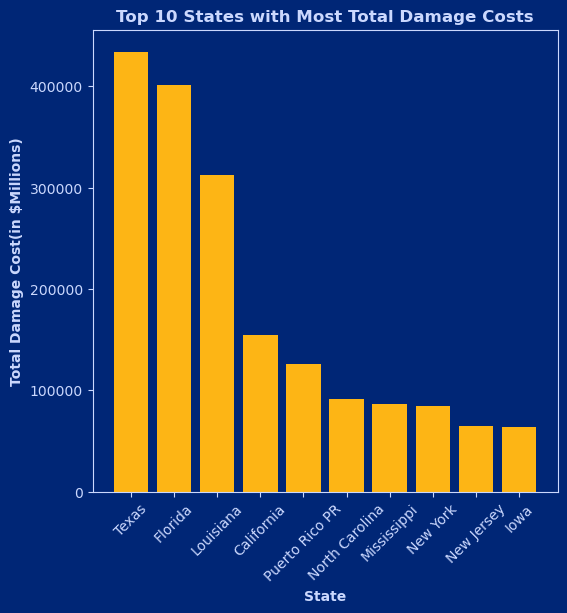

In [24]:
cleaned_state_cost_data = state_cost_data[state_cost_data['state'] != "US"]
cleaned_state_cost_data['state'] = cleaned_state_cost_data['state'].apply(state_name)

cleaned_state_cost_data["total damage"] = cleaned_state_cost_data.iloc[:,1:].sum(axis=1)
top_10_damages = cleaned_state_cost_data.sort_values(by="total damage", ascending=False).head(10)

plt.figure(figsize=(6,6))
plt.bar(top_10_damages["state"], top_10_damages["total damage"], color=config.graph)
plt.title("Top 10 States with Most Total Damage Costs", fontdict={'weight':'bold'},color=config.text)
plt.xlabel("State", fontdict={'weight':'bold'},color=config.text)
plt.ylabel("Total Damage Cost(in $Millions)", fontdict={'weight':'bold'},color=config.text)
plt.xticks(rotation=45)
apply_plot_config()

pass

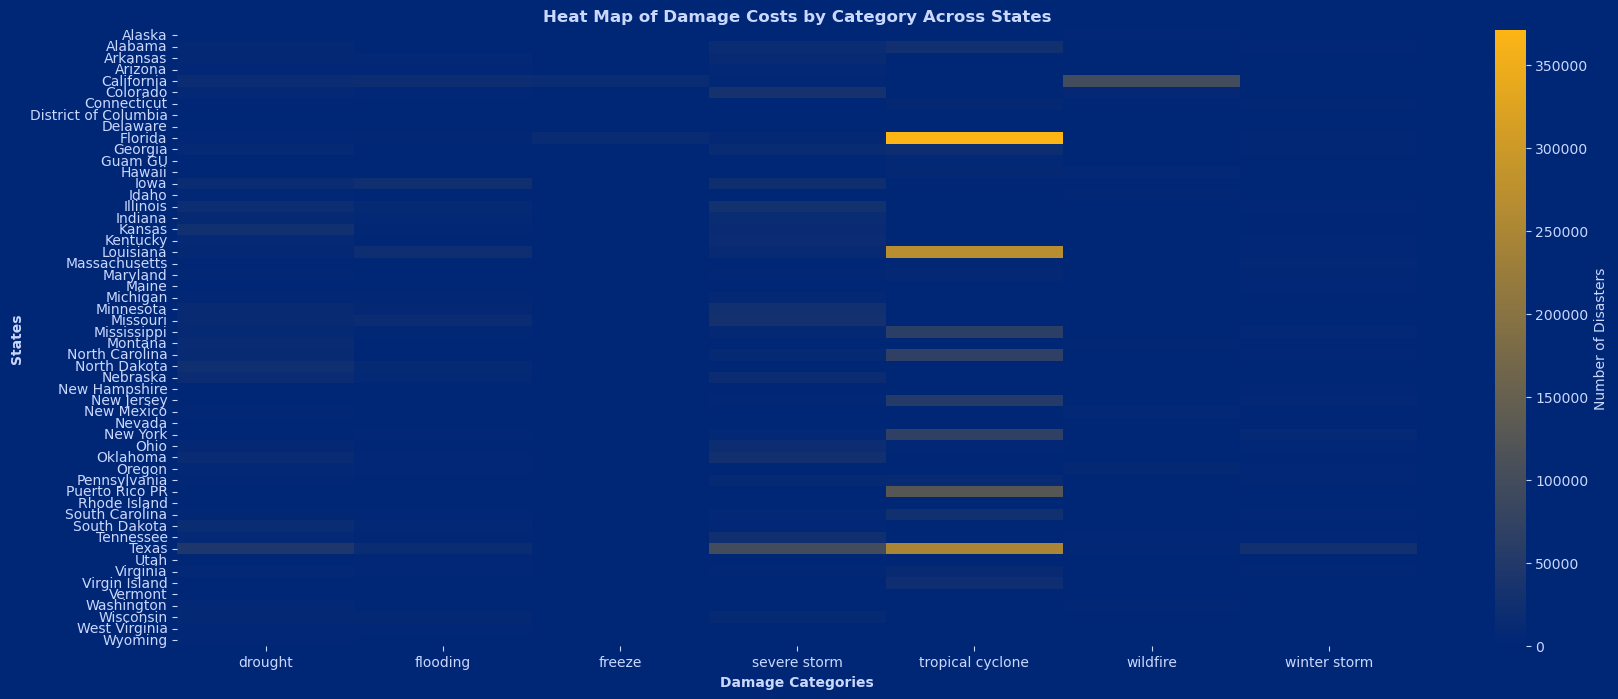

In [25]:
heatmap_data = cleaned_state_cost_data.set_index("state").iloc[:,:-1]
plt.figure(figsize=(20,8))
berkeley_prim_grad = sns.color_palette("blend:#002676,#FDB515", as_cmap=True)
ax = sns.heatmap(heatmap_data, annot=False, cmap=berkeley_prim_grad, cbar=True, yticklabels=heatmap_data.index)
plt.title("Heat Map of Damage Costs by Category Across States", fontdict={'weight':'bold'},color=config.text)
plt.xlabel("Damage Categories", fontdict={'weight':'bold'},color=config.text)
plt.ylabel("States", fontdict={'weight':'bold'},color=config.text)
plt.gca().set_facecolor('white')
# Access the color bar
colorbar = ax.collections[0].colorbar
# Change the color bar tick label color
colorbar.ax.yaxis.set_tick_params(color=config.text)  # Change tick label color
# Change the color bar title config.text color (if a title is set)
colorbar.ax.tick_params(colors=config.text)
colorbar.set_label('Number of Disasters', color=config.text)
apply_plot_config()
plt.show()

In [34]:
state_freq_data.columns

Index(['year', 'state', 'drought', 'flooding', 'freeze', 'severe storm',
       'tropical cyclone', 'wildfire', 'winter storm'],
      dtype='object')

Using this new dataset, plot historical trend with natural disasters from 1980-2024

In [33]:
freq_trend

year  state
1980  AK       0
      AL       1
      AR       2
      AZ       0
      CA       0
              ..
2024  VT       1
      WA       1
      WI       4
      WV       1
      WY       0
Length: 2430, dtype: int64

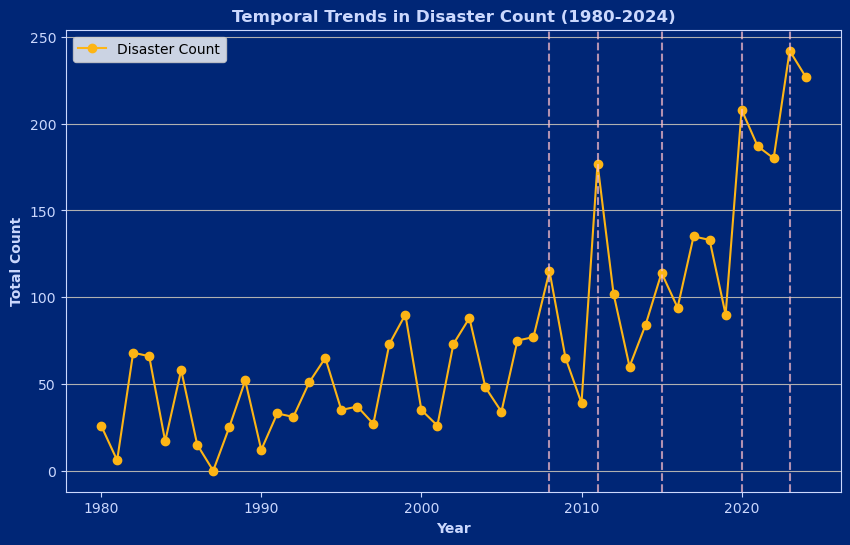

In [ ]:
freq_trend =  state_freq_data.groupby('year')[['drought', 'flooding', 'freeze', 'severe storm','tropical cyclone', 'wildfire', 'winter storm']].sum().sum(axis=1)
# Grouping spike years to zoom in on them in a later graph
spike_years = [2011, 2008, 2015, 2020, 2023]
spike_years_data = state_freq_data[state_freq_data['year'].isin(spike_years)]
spike_years_summary = spike_years_data.groupby('year').sum()

# Plot Temporal Trend
plt.figure(figsize=(10, 6))
plt.plot(freq_trend.index, freq_trend.values, label="Disaster Count", marker='o', color=config.graph)
for year in spike_years:
    plt.axvline(x=year, color='pink', linestyle='--', alpha=0.7)
plt.title("Temporal Trends in Disaster Count (1980-2024)",color=config.text,fontweight='bold')
plt.xlabel("Year",color=config.text,fontweight='bold')
plt.ylabel("Total Count",color=config.text,fontweight='bold')
plt.legend()
plt.grid(True, axis='y')
apply_plot_config()
pass

### Plot distribution of disasters in spike years

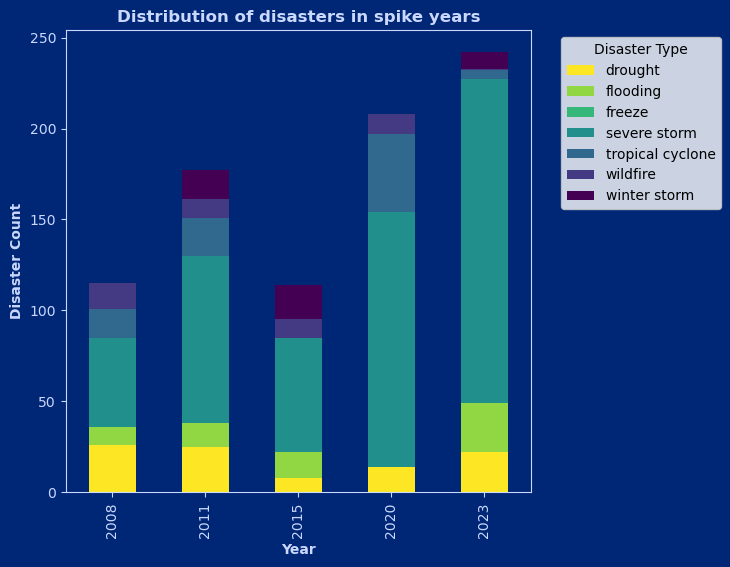

In [ ]:
spike_years_summary.drop(columns="year", errors="ignore")
spike_years_summary.plot(kind="bar",stacked=True, figsize=(6, 6),colormap='viridis_r')
plt.title("Distribution of disasters in spike years",weight='bold',color=config.text)
plt.xlabel("Year",fontdict={'weight': 'bold'},color=config.text)
plt.ylabel("Disaster Count",fontdict={'weight': 'bold'},color=config.text)
plt.legend(title="Disaster Type", bbox_to_anchor=(1.05, 1), loc="upper left")
apply_plot_config()

## End